In [1]:
import argparse
import datetime
import os
from os.path import basename, dirname, join

import glob

import numpy as np
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')
import matplotlib.pyplot as plt
import random

from tensorflow import keras
from tensorflow.keras.layers.experimental.preprocessing import Resizing 
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

from archive import Archive
from data_generator import DataGeneratorFrom_npz_File, DataGenerator
from utility import Configure, between_zero_and_one_float_type
from train_model import FileBasedConfigure

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

from netCDF4 import Dataset
from keras.models import load_model

import warnings
from IPython.core.debugger import Pdb
ipdb = Pdb()

from hot_encoding_utils import ice_type, one_hot_binary, one_hot_continous

In [2]:
warnings.filterwarnings('ignore')

In [3]:
def generate_test_dataset(mode):
    if mode == 'binary':
        idir ='C:/Users/User/NANSEN/test_dataset_1105/binary_output_128'
    else :
        idir ='C:/Users/User/NANSEN/test_dataset_1105/continuous_output_128'
    train_ratio = 1
    npz_files = sorted(glob.glob(f'{idir}/*npz'))

    input_var_names = ['nersc_sar_primary', 'nersc_sar_secondary']
    amsr2_var_names = [
        'btemp_6_9h',
        'btemp_6_9v',
        'btemp_7_3h',
        'btemp_7_3v',
        'btemp_10_7h',
        'btemp_10_7v',
        'btemp_18_7h',
        'btemp_18_7v',
        'btemp_23_8h',
        'btemp_23_8v',
        'btemp_36_5h',
        'btemp_36_5v',
        'btemp_89_0h',
        'btemp_89_0v',
     ]
    output_var_name = 'ice_type'

    dims_input = np.load(npz_files[0])[input_var_names[0]].shape
    dims_output = np.load(npz_files[0])[output_var_name].shape
    dims_amsr2 = np.load(npz_files[0])[amsr2_var_names[0]].shape

    params = {'dims_input':      (*dims_input, len(input_var_names)),
                           'dims_output':     (*dims_output,),
                           'dims_amsr2':      (*dims_amsr2, len(amsr2_var_names)),
                           'output_var_name': output_var_name,
                           'input_var_names': input_var_names,
                           'amsr2_var_names': amsr2_var_names,
                           'batch_size':      20,
                           'shuffle_on_epoch_end': False,
                           }



    test_dataset = DataGeneratorFrom_npz_File(npz_files, **params)
    return test_dataset

In [5]:
def models_list(loss):
    dir_ = 'C:/Users/User/NANSEN/Models/'+loss+'/'
    
    if loss == 'cc':
        loss_function = 'categorical_crossentropy'
    else:
        loss_function = loss
        
    list_binary =[]  
    list_continuous = [] 
    
    for file in glob.glob(dir_+"binary_chosen*"):
        model_binary = tf.keras.models.load_model(file, compile=False)
        model_binary.compile(Adam(learning_rate=1e-4), loss=loss_function, metrics=['accuracy'])
        model_binary.load_weights(file).expect_partial()
        list_binary.append(model_binary)
       
    for file in glob.glob(dir_+"continuous_chosen*"):
        model_continuous = tf.keras.models.load_model(file, compile=False)
        model_continuous.compile(Adam(learning_rate=1e-4), loss=loss_function, metrics=['accuracy'])
        model_continuous.load_weights(file).expect_partial()
        list_continuous.append(model_continuous)
        
         
    return list_binary, list_continuous

In [6]:
def predict(list_models_binary, list_models_continuous,test_dataset_binary,test_dataset_continuous):
    

    for i in range(len(list_models_binary)):
        prediction_binary = list_models_binary[i].predict(test_dataset_binary)
        list_prediction_binary.append(prediction_binary)
        
    for j in range(len(list_models_continuous)):
        prediction_continuous = list_models_continuous[j].predict(test_dataset_continuous)
        list_prediction_continuous.append(prediction_continuous)
        
    return list_prediction_binary,list_prediction_continuous

In [7]:
loss_list = ['cc']
test_dataset_binary = generate_test_dataset('binary')
test_dataset_continuous = generate_test_dataset('continuous')

binary_predictions_for_loss=[]
continuous_predictions_for_loss=[]

for loss in loss_list:
    list_prediction_binary=[]
    list_prediction_continuous=[]
    list_models_binary=models_list(loss)[0]

    list_models_binary[0], list_models_binary[1] = list_models_binary[1], list_models_binary[0]
    list_models_continuous = models_list(loss)[1]
    list_models_continuous[0], list_models_continuous[1] = list_models_continuous[1], list_models_continuous[0]

    
    binary_prediction, continuous_prediction = predict(list_models_binary, list_models_continuous,test_dataset_binary,test_dataset_continuous)
    
    list_prediction_binary.append(binary_prediction)
    list_prediction_continuous.append(continuous_prediction)
    
    binary_predictions_for_loss.append(list_prediction_binary)
    continuous_predictions_for_loss.append(list_prediction_continuous)
    

In [9]:
def initialise_fig():
    fig, ax = plt.subplots(3,4,figsize=(25,25))
    fig.tight_layout(pad=3.0)
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
    plt.subplots_adjust( wspace=0, hspace=0, top=0.76)
    for k in range(1,3):
        fig.delaxes(ax[k,2])
        fig.delaxes(ax[k,3])

    cols = ['binary', 'continuous']
    cols.insert(0,' ')
    rows = ['{}'.format(row) for row in ['','Conf2.5','Conf_4']]

    for axe, col in zip(ax[1], cols):
            axe.annotate(col, xy=(0.5, 1), xytext=(1, 1),
                        xycoords='axes fraction', textcoords='offset points',
                        size='large', ha='center', va='baseline')

    for axe, row in zip(ax[:,0], rows):
        axe.annotate(row, xy=(0, 0.5), xytext=(-axe.yaxis.labelpad - 0.5, 0),
                    xycoords=axe.yaxis.label, textcoords='offset points',
                    size='large', ha='right', va='center')
    return fig, ax

In [10]:
names_ice_types=['Water', 'First-year Ice', 'Multi-year Ice']

In [11]:
def sar_ice_type(fig, ax, patch_name, icetype):
    method =['binary', 'continuous']
    for i in range(len(method)):
        sar1 = np.load('C:/Users/User/NANSEN/test_dataset_1105/binary_output_128/'+patch_name+'.npz')['nersc_sar_primary']
        sar2 = np.load('C:/Users/User/NANSEN/test_dataset_1105/binary_output_128/'+patch_name+'.npz')['nersc_sar_secondary']

        icetype_ic = np.load('C:/Users/User/NANSEN/test_dataset_1105/'+method[i]+'_output_128/'+patch_name+'.npz')['ice_type'][:,:,icetype].astype(np.float32)
        
        ax[0, 2].imshow(sar1,  cmap='gray')
        ax[0, 3].imshow(sar2,  cmap='gray')
        
        ax[0, i].imshow(icetype_ic, clim = [0,1])
        ax[0, 2].set_title('SAR H')
        ax[0, 3].set_title('SAR V')
        ax[0, i].set_title(names_ice_types[icetype]+' '+method[i])

    return fig, ax

In [12]:
def show_patch(list_binary, list_continuous, fig, ax,  patch_number, icetype):

    for i in range(2):
        ice_pred = list_binary[i] [patch_number,:,:,icetype].astype(np.float32)
        ax[i+1,0].imshow(ice_pred, clim = [0,1])

        
    for j in range(2):
        ice_pred = list_continuous[j] [patch_number,:,:,icetype].astype(np.float32)
        ax[j+1,1].imshow(ice_pred, clim = [0,1])

    plt.show()

In [ ]:
patch_name = ['20180818T085755_000167', '20180818T085755_000307','20180818T085755_000459', '20180818T085755_000698', '20180818T085755_001008', '20180818T085755_001375', '20180818T085755_001492', '20180818T085755_001038']
patch_number =[ 37, 148, 300, 539, 770, 924, 959, 785]
final_loss_list = [0, 1]
prediction_list_binary=[]
prediction_list_continuous=[]
loss=0
ice_types_list=[i for i in range(3)]

    
for numb in range(len(patch_number)):
    for i in range(len(loss_list)):
        for icetype in ice_types_list:
            print(loss_list[i])
            list_binary = binary_predictions_for_loss[i] 

            list_continuous = continuous_predictions_for_loss[i]

    plt.show()
    

In [14]:
import netCDF4 as nc
stp = 20
dir_ = "C:/Users/User/NANSEN/test_dataset_1105/"
ifiles = sorted(glob.glob(dir_+'*.nc'))



ifile = ifiles[0]
ds = nc.Dataset(ifile)
r,s =ds['nersc_sar_secondary'].shape
sar2 = ds['nersc_sar_secondary'][::stp, ::stp]
ic = ds['polygon_icechart'][::stp, ::stp]

n,p= ic.shape


en_values_array=np.zeros((n,p,3))+np.nan

map_id_to_variable_values=dict()
for id_and_corresponding_variable_values in ds['polygon_codes'][1:]:
    id_val_splitted = id_and_corresponding_variable_values.split(";")

    [ct, ca, sa, fa, cb, sb, fb, cc, sc, fc] = list(map(int, id_val_splitted[1:11]))

    result = one_hot_continous(ct,ca,sa,fa,cb,sb,fb,cc,sc,fc)

    map_id_to_variable_values.update({int(id_val_splitted[0]): result})




for id_value, variable_belong_to_id in map_id_to_variable_values.items():


    en_values_array[ic == id_value, :] =np.array(variable_belong_to_id)
    
    
dir_2 = "C:/Users/User/NANSEN/test_dataset_1105/binary_output_128"
ifiles_recon = glob.glob(dir_2+'/*.npz')
patch_locs=np.asarray(list(np.load(ifiles_recon[0])['loc']))
ice_types= [np.load(ifiles_recon[0])['ice_type']]
for i in range(1,len(ifiles_recon)):
    file=np.load(ifiles_recon[i])
#     print(np.array(file['loc']))
    patch_locs=np.dstack((patch_locs,np.asarray(list(file['loc']))))
    ice_types.append(file['ice_type'])
patch_locs=np.transpose(patch_locs[0])

    
dir_3 = "C:/Users/User/NANSEN/test_dataset_1105/continuous_output_128"
ifiles_recon = glob.glob(dir_3+'/*.npz')
ice_types_cont= [np.load(ifiles_recon[0])['ice_type']]
for i in range(1,len(ifiles_recon)):
    file=np.load(ifiles_recon[i])
    ice_types_cont.append(file['ice_type'])

In [ ]:
fig, ax = plt.subplots(6,3, figsize=(25,50))
fig.tight_layout(pad=1.0)
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
plt.subplots_adjust( wspace=0, hspace=0)
fig.delaxes(ax[0,2])
sar1 = ds['nersc_sar_primary'][::stp, ::stp]
sar2 = ds['nersc_sar_secondary'][::stp, ::stp]
ax[0,0].imshow(sar1, cmap='gray',clim=[-30, -10] )
ax[0,1].imshow(sar2, cmap='gray',clim=[-30, -23] )

cols = ['WATER', 'FIRST-YEAR ICE', 'MULTY-YEAR ICE']
# cols.insert(0,' ')
rows = ['{}'.format(row) for row in ['SAR','ICE CHART CONTINUOUS','CONF 1 BINARY','CONF 1 CONTINUOUS', 'CONF 2 BINARY', 'CONF 2 CONTINUOUS']]

for axe, col in zip(ax[1], cols):
        axe.annotate(col, xy=(0.5, 1), xytext=(1, 1),
                    xycoords='axes fraction', textcoords='offset points',
                    size='large', ha='center', va='baseline',fontsize = 30.0)

for axe, row in zip(ax[:,0], rows):
    axe.annotate(row, xy=(0, 0.5), xytext=(-axe.yaxis.labelpad - 0.5, 0),
                xycoords=axe.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center',fontsize = 30.0)
stride = 128   
conf=0
recon_binary=[]
recon_continuous=[]
for i in range(len(list_binary)-1):
    
    pred_binary= list_binary[i]
    pred_continuous = list_continuous[i]
    img_locs = np.multiply(patch_locs, (stride,stride))
    ws0, ws1 = 256, 256
    img_binary = np.zeros((r,s,3))
    img_continuous = np.zeros((r,s,3))
    img_ice = np.zeros((r,s,3))
    for j in range(pred_binary.shape[0]):
        img_binary[
                img_locs[j][0]+50:img_locs[j][0]-50 + ws0,
                img_locs[j][1]+50:img_locs[j][1]-50 + ws1
                ] = pred_binary[j,50:-50,50:-50,:]
        img_continuous[
                img_locs[j][0]+50:img_locs[j][0]-50 + ws0,
                img_locs[j][1]+50:img_locs[j][1]-50 + ws1
                ] = pred_continuous[j,50:-50,50:-50,:]
        img_ice[
                img_locs[j][0]+50:img_locs[j][0]-50 + ws0,
                img_locs[j][1]+50:img_locs[j][1]-50 + ws1
                ] = ice_types[j][50:-50,50:-50,:]
    recon_binary.append(img_binary)
    recon_continuous.append(img_continuous)
        
    


In [21]:
import sklearn

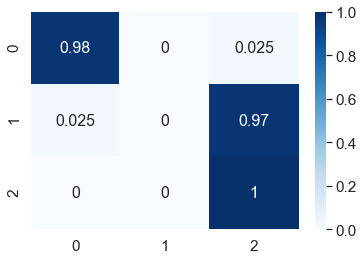

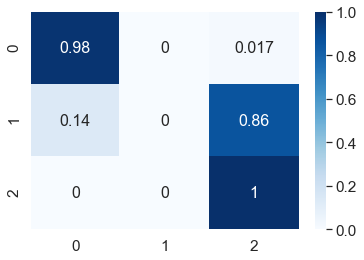

Configuration 0
Accuracy score Binary: 0.809779788562492
Accuracy score Continuous: 0.8159351920700748
Confusion matrix of conf 0  in binary 
 [[0.97544565 0.         0.02455435]
 [0.02531705 0.         0.97468295]
 [0.         0.         1.        ]]
Confusion matrix of conf 0  in continuous 
 [[0.9828756  0.         0.0171244 ]
 [0.13807802 0.         0.86192198]
 [0.         0.         1.        ]]


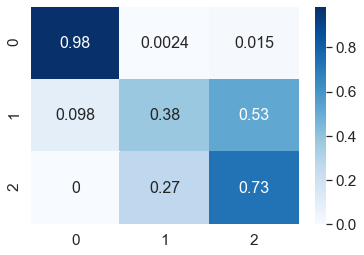

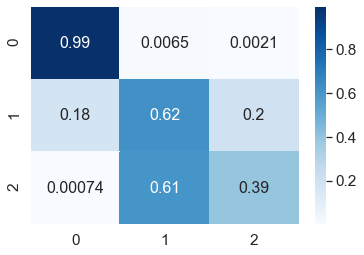

Configuration 1
Accuracy score Binary: 0.8793838822518768
Accuracy score Continuous: 0.9273517959520197
Confusion matrix of conf 1  in binary 
 [[0.98270115 0.0024058  0.01489306]
 [0.09774518 0.37696408 0.52529074]
 [0.         0.26728185 0.73271815]]
Confusion matrix of conf 1  in continuous 
 [[9.91447023e-01 6.49029667e-03 2.06268080e-03]
 [1.78969341e-01 6.20011752e-01 2.01018907e-01]
 [7.37065088e-04 6.06825107e-01 3.92437828e-01]]


In [25]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score

import seaborn as sn
import pandas as pd


recon_binary=[]
recon_continuous=[]
for i in range(len(list_binary)-1):
    
    pred_binary= list_binary[i]
    pred_continuous = list_continuous[i]
    img_locs = np.multiply(patch_locs, (stride,stride))
    ws0, ws1 = 256, 256
    img_binary = np.zeros((r,s,3))
    img_continuous = np.zeros((r,s,3))
    img_ice = np.zeros((r,s,3))
    img_ice_cont = np.zeros((r,s,3))
    for j in range(pred_binary.shape[0]):
        # assembling every single output of ML network into correct place of image one by one
        img_binary[
                img_locs[j][0]+50:img_locs[j][0]-50 + ws0,
                img_locs[j][1]+50:img_locs[j][1]-50 + ws1
                ] = pred_binary[j,50:-50,50:-50,:]
        img_continuous[
                img_locs[j][0]+50:img_locs[j][0]-50 + ws0,
                img_locs[j][1]+50:img_locs[j][1]-50 + ws1
                ] = pred_continuous[j,50:-50,50:-50,:]
        img_ice[
                img_locs[j][0]+50:img_locs[j][0]-50 + ws0,
                img_locs[j][1]+50:img_locs[j][1]-50 + ws1
                ] = ice_types[j][50:-50,50:-50,:]
        img_ice_cont[
                img_locs[j][0]+50:img_locs[j][0]-50 + ws0,
                img_locs[j][1]+50:img_locs[j][1]-50 + ws1
                ] = ice_types_cont[j][50:-50,50:-50,:]
    recon_binary.append(img_binary)
    recon_continuous.append(img_continuous)
        
    label_binary = tf.argmax(img_ice, axis = -1)
    label_cont = tf.argmax(img_ice_cont, axis = -1)
    pred_binary = tf.argmax(recon_binary[i], axis = -1)
    pred_cont = tf.argmax(recon_continuous[i], axis = -1)
    cf_mat = confusion_matrix(np.array(label_binary).astype(float).ravel(), np.array(pred_binary).astype(float).ravel(), normalize='true')
    cf_mat_cont = confusion_matrix(np.array(label_cont).astype(float).ravel(), np.array(pred_cont).astype(float).ravel(), normalize='true')
    
    df_cm = pd.DataFrame(cf_mat, range(3), range(3))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap='Blues') # font size

    plt.show()
    
    df_cm = pd.DataFrame(cf_mat_cont, range(3), range(3))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap='Blues') # font size

    plt.show()

    print("Configuration", i)
    print ('Accuracy score Binary:', accuracy_score(np.array(label_binary).astype(float).ravel(), np.array(pred_binary).astype(float).ravel()))
    print ('Accuracy score Continuous:', accuracy_score(np.array(label_cont).astype(float).ravel(), np.array(pred_cont).astype(float).ravel()))
    print("Confusion matrix of conf",i," in binary \n",cf_mat)
    print("Confusion matrix of conf",i," in continuous \n",cf_mat_cont)